# Análisis de Resultados Task 1 - Metabu

Este notebook analiza los resultados del Task 1, mostrando la comparación entre diferentes meta-features usando gráficos de cajas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 11

# Cargar datos
results_file = 'results_task1/task1_results.csv'
df = pd.read_csv(results_file)

print(f"Total de registros: {len(df)}")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nPipelines: {df['pipeline'].unique()}")
print(f"Meta-features: {df['metafeature'].unique()}")
print(f"Valores de k: {sorted(df['ndcg'].unique())}")
print(f"\nPrimeras filas:")
df.head()


Total de registros: 3073

Columnas: ['pipeline', 'metafeature', 'openml_tid', 'ndcg', 'ndcg_score']

Pipelines: ['adaboost' 'random_forest' 'libsvm_svc']
Meta-features: ['metabu' 'AutoSklearn' 'Landmark' 'SCOT']
Valores de k: [np.int64(10), np.int64(15), np.int64(20), np.int64(25)]

Primeras filas:


,pipeline,metafeature,openml_tid,ndcg,ndcg_score
0,adaboost,metabu,3,15,0.533333
1,adaboost,metabu,3,10,0.600000
2,adaboost,metabu,6,10,0.600000
3,adaboost,metabu,11,10,0.600000
4,adaboost,metabu,12,10,0.500000


In [2]:
# Mapeo de nombres para mejor visualización
metafeature_names = {
    'metabu': 'Metabu MF',
    'AutoSklearn': 'AutoSklearn MF',
    'Landmark': 'Landmark MF',
    'SCOT': 'SCOT MF'
}

# Crear columna con nombres formateados
df['metafeature_label'] = df['metafeature'].map(metafeature_names)

# Verificar distribución de datos
print("Distribución por pipeline y meta-feature:")
print(df.groupby(['pipeline', 'metafeature']).size().unstack(fill_value=0))


Distribución por pipeline y meta-feature:
metafeature    AutoSklearn  Landmark  SCOT  metabu
pipeline                                          
adaboost               256       256   256     257
libsvm_svc             256       256   256     256
random_forest          256       256   256     256


## Gráficos de Cajas por Pipeline

Para cada pipeline, mostramos gráficos de cajas donde:
- **Eje X**: Valores de k evaluados (NDCG@k)
- **Eje Y**: NDCG score
- **4 cajas por cada k**, una para cada meta-feature


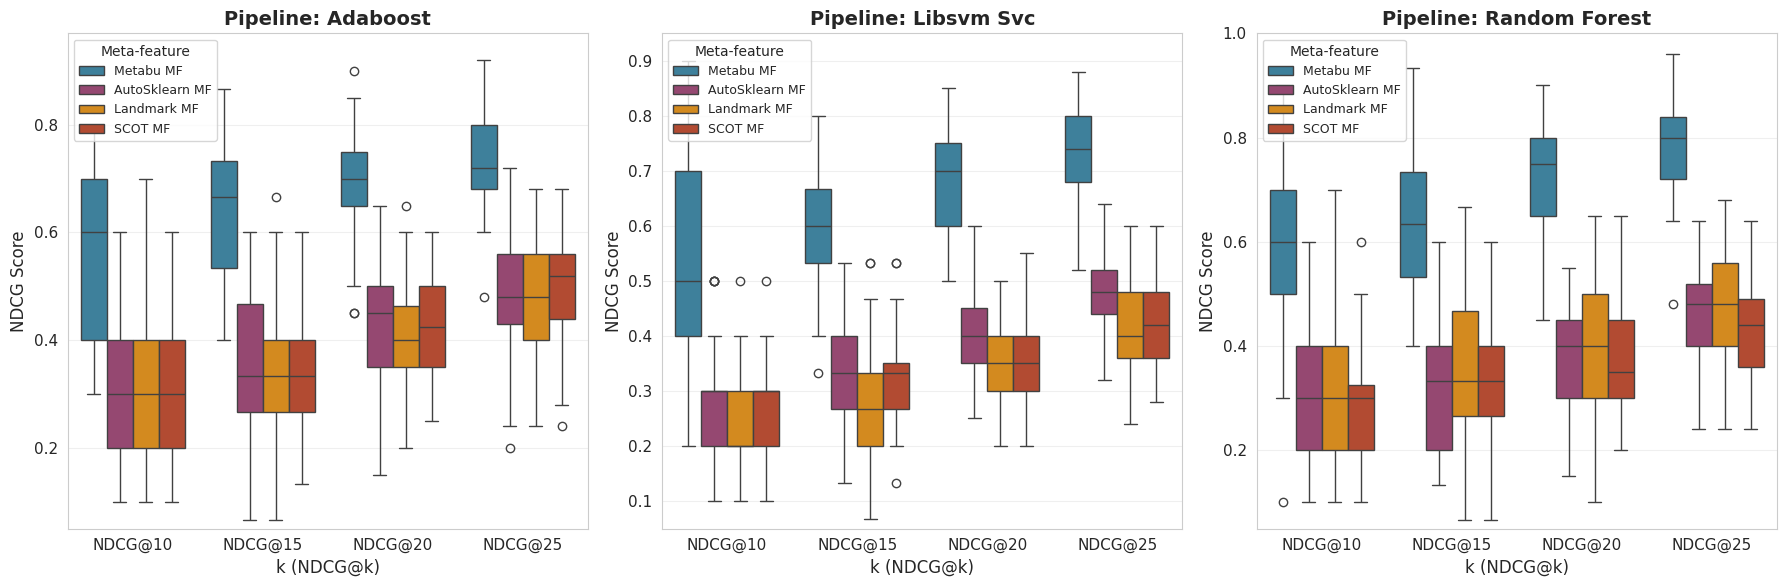

In [3]:
# Ordenar meta-features para consistencia en todos los gráficos
metafeature_order = ['Metabu MF', 'AutoSklearn MF', 'Landmark MF', 'SCOT MF']
df['metafeature_label'] = pd.Categorical(df['metafeature_label'], categories=metafeature_order, ordered=True)

# Obtener pipelines únicos
pipelines = sorted(df['pipeline'].unique())
n_pipelines = len(pipelines)

# Colores para cada meta-feature
colors = {'Metabu MF': '#2E86AB', 'AutoSklearn MF': '#A23B72', 'Landmark MF': '#F18F01', 'SCOT MF': '#C73E1D'}

# Crear subplots usando seaborn (más limpio)
fig, axes = plt.subplots(1, n_pipelines, figsize=(6*n_pipelines, 6))

if n_pipelines == 1:
    axes = [axes]

for idx, pipeline in enumerate(pipelines):
    ax = axes[idx]
    pipeline_data = df[df['pipeline'] == pipeline].copy()
    
    # Crear columna combinada para el eje X: k + metafeature
    pipeline_data['k_label'] = pipeline_data['ndcg'].astype(str).apply(lambda x: f"NDCG@{x}")
    
    # Calcular rango dinámico del eje Y basado en los datos
    # Separar Metabu de los baselines para mejor visualización
    metabu_data = pipeline_data[pipeline_data['metafeature_label'] == 'Metabu MF']['ndcg_score']
    baselines_data = pipeline_data[pipeline_data['metafeature_label'] != 'Metabu MF']['ndcg_score']
    
    # Calcular rangos separados
    metabu_min = metabu_data.min() if len(metabu_data) > 0 else 0
    metabu_max = metabu_data.max() if len(metabu_data) > 0 else 1
    baselines_min = baselines_data.min() if len(baselines_data) > 0 else 0
    baselines_max = baselines_data.max() if len(baselines_data) > 0 else 1
    
    # Rango global ajustado que muestre bien tanto Metabu como baselines
    y_min = min(metabu_min, baselines_min)
    y_max = max(metabu_max, baselines_max)
    y_min_adjusted = max(0.05, y_min - 0.08)  # Pequeño margen inferior, mínimo 0.05
    y_max_adjusted = min(1.0, y_max + 0.05)  # Pequeño margen superior
    
    # Boxplot usando seaborn
    sns.boxplot(data=pipeline_data, 
                x='k_label', 
                y='ndcg_score', 
                hue='metafeature_label',
                ax=ax,
                palette=colors,
                order=[f"NDCG@{k}" for k in sorted(pipeline_data['ndcg'].unique())])
    
    ax.set_ylabel('NDCG Score', fontsize=12)
    ax.set_xlabel('k (NDCG@k)', fontsize=12)
    ax.set_title(f'Pipeline: {pipeline.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    ax.set_ylim(y_min_adjusted, y_max_adjusted)  # Rango dinámico ajustado a los datos
    ax.legend(title='Meta-feature', title_fontsize=10, fontsize=9, loc='best')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results_task1/boxplot_task1_by_pipeline.png', dpi=300, bbox_inches='tight')
plt.show()


## Estadísticas Resumidas

Calculemos promedios y desviaciones estándar por pipeline, meta-feature y k:


## Curva de Aprendizaje Clásica: Tamaño de Entrenamiento vs Rendimiento

Esta es la curva de aprendizaje clásica que muestra cómo mejora el rendimiento de Metabu (metafeatx) al aumentar el tamaño del conjunto de entrenamiento. 

**Configuración del experimento:**
- Variamos el tamaño de entrenamiento: [5, 10, 15, 20, 30, 40, 50, 63] tareas
- Evaluamos en 12 tareas de test representativas
- Hacemos 3 repeticiones con diferentes subconjuntos aleatorios para cada tamaño
- Solo Metabu (metafeatx), todos los pipelines, todos los valores de k


In [4]:
# Cargar resultados de curva de aprendizaje
learning_curve_file = 'results_learning_curve/learning_curve_results.csv'

try:
    lc_df = pd.read_csv(learning_curve_file)
    print(f"Datos de curva de aprendizaje cargados: {len(lc_df)} registros")
    print(f"Tamaños de entrenamiento: {sorted(lc_df['train_size'].unique())}")
    print(f"Tareas de test: {len(lc_df['test_task_id'].unique())}")
    print(f"Pipelines: {lc_df['pipeline'].unique()}")
    print(f"Valores de k: {sorted(lc_df['ndcg'].unique())}")
    print(f"\nPrimeros registros:")
    lc_df.head()
except FileNotFoundError:
    print(f"⚠️  Archivo {learning_curve_file} no encontrado.")
    print("Ejecuta primero: python run_learning_curve.py")
    print("\nPara una versión rápida de prueba:")
    print("  python run_learning_curve.py --test")
    lc_df = None


⚠️  Archivo results_learning_curve/learning_curve_results.csv no encontrado.
Ejecuta primero: python run_learning_curve.py

Para una versión rápida de prueba:
  python run_learning_curve.py --test


In [5]:
# Generar curva de aprendizaje si hay datos
if lc_df is not None and len(lc_df) > 0:
    # Calcular promedio y desviación estándar por pipeline, k y tamaño de entrenamiento
    lc_summary = lc_df.groupby(['pipeline', 'ndcg', 'train_size'])['ndcg_score'].agg(['mean', 'std', 'count']).reset_index()
    lc_summary.columns = ['pipeline', 'ndcg', 'train_size', 'mean_ndcg', 'std_ndcg', 'count']
    
    # Crear subplots: una fila por pipeline, una columna por k
    pipelines = sorted(lc_df['pipeline'].unique())
    k_values = sorted(lc_df['ndcg'].unique())
    
    fig, axes = plt.subplots(len(pipelines), len(k_values), 
                             figsize=(6*len(k_values), 5*len(pipelines)))
    
    if len(pipelines) == 1:
        axes = axes.reshape(1, -1)
    if len(k_values) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, pipeline in enumerate(pipelines):
        for j, k_val in enumerate(k_values):
            ax = axes[i, j]
            
            # Filtrar datos para este pipeline y k
            pipeline_k_data = lc_summary[
                (lc_summary['pipeline'] == pipeline) & 
                (lc_summary['ndcg'] == k_val)
            ].sort_values('train_size')
            
            if len(pipeline_k_data) > 0:
                # Plotear línea con barras de error
                ax.errorbar(
                    pipeline_k_data['train_size'],
                    pipeline_k_data['mean_ndcg'],
                    yerr=pipeline_k_data['std_ndcg'],
                    marker='o',
                    linewidth=2,
                    markersize=8,
                    capsize=5,
                    capthick=2,
                    color='#2E86AB',
                    label='metafeatx'
                )
                
                # Ajustar límites del eje Y
                y_min = pipeline_k_data['mean_ndcg'].min() - 2 * pipeline_k_data['std_ndcg'].max()
                y_max = pipeline_k_data['mean_ndcg'].max() + 2 * pipeline_k_data['std_ndcg'].max()
                ax.set_ylim(max(0, y_min), min(1, y_max))
            
            ax.set_xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=11)
            ax.set_ylabel('NDCG Score Promedio', fontsize=11)
            ax.set_title(f'{pipeline.replace("_", " ").title()} - NDCG@{k_val}', 
                        fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xticks(pipeline_k_data['train_size'].unique())
            ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.savefig('results_learning_curve/learning_curve_classic.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Guardar resumen
    lc_summary.to_csv('results_learning_curve/learning_curve_summary.csv', index=False)
    print("Resumen guardado en: results_learning_curve/learning_curve_summary.csv")
else:
    print("No hay datos disponibles para generar la curva de aprendizaje.")


No hay datos disponibles para generar la curva de aprendizaje.


In [6]:
# Visualización alternativa: Curva de aprendizaje promediada sobre todas las tareas de test
# Una curva por pipeline y k, mostrando la tendencia clara
if lc_df is not None and len(lc_df) > 0:
    # Calcular promedio sobre todas las tareas de test y repeticiones
    lc_avg = lc_df.groupby(['pipeline', 'ndcg', 'train_size'])['ndcg_score'].agg(['mean', 'std']).reset_index()
    lc_avg.columns = ['pipeline', 'ndcg', 'train_size', 'mean_ndcg', 'std_ndcg']
    
    # Crear gráfico: una línea por pipeline, subplots por k
    k_values = sorted(lc_df['ndcg'].unique())
    pipelines = sorted(lc_df['pipeline'].unique())
    
    colors_pipeline = {
        'adaboost': '#2E86AB',
        'random_forest': '#A23B72',
        'svm': '#F18F01'
    }
    
    fig, axes = plt.subplots(1, len(k_values), figsize=(6*len(k_values), 5))
    if len(k_values) == 1:
        axes = [axes]
    
    for j, k_val in enumerate(k_values):
        ax = axes[j]
        
        for pipeline in pipelines:
            pipeline_data = lc_avg[
                (lc_avg['pipeline'] == pipeline) & 
                (lc_avg['ndcg'] == k_val)
            ].sort_values('train_size')
            
            if len(pipeline_data) > 0:
                ax.plot(
                    pipeline_data['train_size'],
                    pipeline_data['mean_ndcg'],
                    marker='o',
                    linewidth=2,
                    markersize=8,
                    label=pipeline.replace('_', ' ').title(),
                    color=colors_pipeline.get(pipeline, '#2E86AB')
                )
                
                # Rellenar área de incertidumbre (std)
                ax.fill_between(
                    pipeline_data['train_size'],
                    pipeline_data['mean_ndcg'] - pipeline_data['std_ndcg'],
                    pipeline_data['mean_ndcg'] + pipeline_data['std_ndcg'],
                    alpha=0.2,
                    color=colors_pipeline.get(pipeline, '#2E86AB')
                )
        
        ax.set_xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=12)
        ax.set_ylabel('NDCG Score Promedio', fontsize=12)
        ax.set_title(f'Curva de Aprendizaje - NDCG@{k_val}', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(title='Pipeline', title_fontsize=10, fontsize=9, loc='best')
        
        # Ajustar límites del eje Y
        all_data = lc_avg[lc_avg['ndcg'] == k_val]
        y_min = (all_data['mean_ndcg'] - 2*all_data['std_ndcg']).min()
        y_max = (all_data['mean_ndcg'] + 2*all_data['std_ndcg']).max()
        ax.set_ylim(max(0, y_min * 0.95), min(1, y_max * 1.05))
    
    plt.tight_layout()
    plt.savefig('results_learning_curve/learning_curve_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
